In [36]:
import requests
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import Ridge

from sklearn.metrics import mean_absolute_error, mean_squared_error



In [58]:
data = yf.download('EURUSD=X') #, period='', interval='1h')

[*********************100%%**********************]  1 of 1 completed


In [59]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0
2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0
2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0
2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0
2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0
...,...,...,...,...,...,...
2024-03-04,1.084269,1.086649,1.083858,1.084269,1.084269,0
2024-03-05,1.085517,1.087536,1.084269,1.085517,1.085517,0
2024-03-06,1.085600,1.091405,1.084293,1.085600,1.085600,0


In [62]:
df = data[data.index<'2024'][['Open', 'High', 'Low', 'Adj Close']]

In [63]:
# create a baseline metric

df

,Open,High,Low,Adj Close
Date,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501
2003-12-02,1.196101,1.210903,1.194600,1.208897
2003-12-03,1.209000,1.213003,1.207700,1.212298
2003-12-04,1.212004,1.214403,1.204398,1.208094
2003-12-05,1.207802,1.219096,1.206593,1.218695
...,...,...,...,...
2023-12-25,1.102657,1.104240,1.099989,1.102657
2023-12-26,1.102026,1.103997,1.100958,1.102026
2023-12-27,1.104301,1.112248,1.102925,1.104301


In [7]:
data['target'] = data['Adj Close'].shift(-1)

In [17]:
df.isnull().sum()

Open         0
High         0
Low          0
Adj Close    0
target       0
dtype: int64

In [22]:
df.index.year.value_counts().sort_index()

Date
2003     23
2004    261
2005    259
2006    260
2007    258
2008    243
2009    261
2010    261
2011    260
2012    260
2013    260
2014    261
2015    261
2016    261
2017    258
2018    261
2019    260
2020    262
2021    261
2022    260
2023    260
2024     48
Name: count, dtype: int64

<Axes: xlabel='Date'>

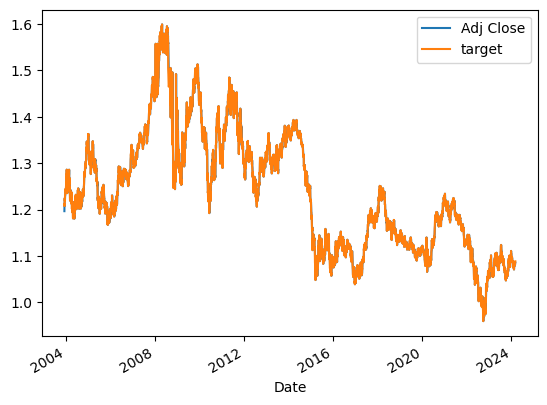

In [24]:
df[['Adj Close','target']].plot()

In [25]:
df.corr()

,Open,High,Low,Adj Close,target
Open,1.000000,0.999363,0.984424,0.999260,0.996528
High,0.999363,1.000000,0.984018,0.999359,0.997285
Low,0.984424,0.984018,1.000000,0.984435,0.982519
Adj Close,0.999260,0.999359,0.984435,1.000000,0.997247
target,0.996528,0.997285,0.982519,0.997247,1.000000


In [28]:
model = Ridge(alpha=1)

In [29]:
predictors = df.columns[~df.columns.isin(['target']) ]

In [30]:
predictors

Index(['Open', 'High', 'Low', 'Adj Close'], dtype='object')

In [31]:
def backtest(df, model, predictors, start=3650, step=90):
    all_predictions = []
    
    for i in range(start, df.shape[0], step):
        train = df.iloc[:i,:]
        test = df.iloc[i:(i+step),:]
        
        model.fit(train[predictors], train["target"])
        
        preds = model.predict(test[predictors])
        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)
        combined.columns = ["actual", "prediction"]
        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()
        
        all_predictions.append(combined)
    return pd.concat(all_predictions)

In [37]:
predictions = backtest(df, model, predictors)

In [38]:

mean_absolute_error(predictions["actual"], predictions["prediction"])

0.003261935374973937

In [44]:
def pct_diff(old, new):
    return (new - old) / old

def compute_rolling(df, horizon, col):
    label = f"rolling_{horizon}_{col}"
    df[label] = df[col].rolling(horizon).mean()
    df[f"{label}_pct"] = pct_diff(df[label], df[col])
    return df
    
rolling_horizons = [3, 14]
for horizon in rolling_horizons:
    for col in predictors.tolist():
        df = compute_rolling(df, horizon, col)

In [45]:
def expand_mean(df):
    return df.expanding(1).mean()

for col in predictors.tolist():
    df[f"month_avg_{col}"] = df[col].groupby(df.index.month, group_keys=False).apply(expand_mean)
    df[f"day_avg_{col}"] = df[col].groupby(df.index.day_of_year, group_keys=False).apply(expand_mean)


In [43]:
predictors.tolist()

['Open', 'High', 'Low', 'Adj Close']

In [49]:
df.columns

Index(['Open', 'High', 'Low', 'Adj Close', 'target', 'rolling_3_Open',
       'rolling_3_Open_pct', 'rolling_3_High', 'rolling_3_High_pct',
       'rolling_3_Low', 'rolling_3_Low_pct', 'rolling_3_Adj Close',
       'rolling_3_Adj Close_pct', 'rolling_14_Open', 'rolling_14_Open_pct',
       'rolling_14_High', 'rolling_14_High_pct', 'rolling_14_Low',
       'rolling_14_Low_pct', 'rolling_14_Adj Close',
       'rolling_14_Adj Close_pct', 'month_avg_Open', 'day_avg_Open',
       'month_avg_High', 'day_avg_High', 'month_avg_Low', 'day_avg_Low',
       'month_avg_Adj Close', 'day_avg_Adj Close'],
      dtype='object')

In [51]:
predictions2 = backtest(df.dropna(), model, df.columns)

In [52]:
predictions2

,actual,prediction,diff
Date,,,
2018-01-23,1.231027,1.227482,0.003545
2018-01-24,1.239111,1.233865,0.005246
2018-01-25,1.239234,1.239199,0.000035
2018-01-26,1.242807,1.240931,0.001876
2018-01-29,1.238114,1.239977,0.001863
...,...,...,...
2024-02-29,1.080497,1.082687,0.002190
2024-03-01,1.084269,1.082631,0.001638
2024-03-04,1.085517,1.084680,0.000837


In [53]:
mean_absolute_error(predictions2["actual"], predictions2["prediction"])

0.002217574077250788

In [54]:
df

,Open,High,Low,Adj Close,target,rolling_3_Open,rolling_3_Open_pct,rolling_3_High,rolling_3_High_pct,rolling_3_Low,...,rolling_14_Adj Close,rolling_14_Adj Close_pct,month_avg_Open,day_avg_Open,month_avg_High,day_avg_High,month_avg_Low,day_avg_Low,month_avg_Adj Close,day_avg_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-01,1.203398,1.204007,1.194401,1.196501,1.208897,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.203398,1.203398,1.204007,1.204007,1.194401,1.194401,1.196501,1.196501
2003-12-02,1.196101,1.210903,1.194600,1.208897,1.212298,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.199750,1.196101,1.207455,1.210903,1.194501,1.194600,1.202699,1.208897
2003-12-03,1.209000,1.213003,1.207700,1.212298,1.208094,1.202833,0.005127,1.209304,0.003059,1.198900,...,NaN,NaN,1.202833,1.209000,1.209304,1.213003,1.198900,1.207700,1.205899,1.212298
2003-12-04,1.212004,1.214403,1.204398,1.208094,1.218695,1.205701,0.005227,1.212770,0.001347,1.202233,...,NaN,NaN,1.205126,1.212004,1.210579,1.214403,1.200275,1.204398,1.206448,1.208094
2003-12-05,1.207802,1.219096,1.206593,1.218695,1.222001,1.209602,-0.001488,1.215501,0.002958,1.206231,...,NaN,NaN,1.205661,1.207802,1.212282,1.219096,1.201539,1.206593,1.208897,1.218695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29,1.083882,1.085588,1.080567,1.083882,1.080497,1.084485,-0.000557,1.085639,-0.000048,1.081266,...,1.079711,0.003862,1.231397,1.233473,1.235778,1.236422,1.226784,1.227219,1.231457,1.232218
2024-03-01,1.080497,1.084152,1.079925,1.080497,1.084269,1.082953,-0.002268,1.084819,-0.000615,1.080120,...,1.079760,0.000683,1.237440,1.209839,1.242470,1.213824,1.229022,1.204988,1.237631,1.209880
2024-03-04,1.084269,1.086649,1.083858,1.084269,1.085517,1.082883,0.001281,1.085463,0.001093,1.081450,...,1.080263,0.003709,1.237099,1.237456,1.242122,1.240177,1.228698,1.231891,1.237289,1.236657
